## HW6 Histogramm with pycuda

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

(701, 1024, 3)

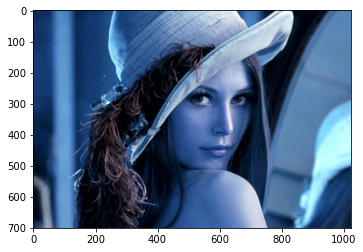

In [2]:
h_img = cv2.imread('images/lena.jpg').astype(np.int32)
display(h_img.shape)

plt.imshow(h_img)
plt.show()

In [3]:
block_size = 16

rows = h_img.shape[1]
cols = h_img.shape[0]

block = (block_size, block_size, 1)
grid = ((rows + block_size - 1) // block[0], (cols + block_size - 1) // block[1])

display((cols, rows))

(701, 1024)

In [4]:
d_img = cuda.mem_alloc(h_img.nbytes)
cuda.memcpy_htod(d_img, h_img)
d_img

In [5]:
bin_count = 128

h_bins = np.linspace(0, 256, bin_count + 1, dtype=np.int32)
d_bins = cuda.mem_alloc(h_bins.nbytes)
cuda.memcpy_htod(d_bins, h_bins)
h_bins

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206,
       208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232,
       234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256],
      dtype=int32)

In [6]:
h_hist = np.zeros(bin_count, dtype=np.int32)
d_hist = cuda.mem_alloc(h_hist.nbytes)
cuda.memcpy_htod(d_hist, h_hist)
h_hist

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [7]:
histogramModule = SourceModule("""
  __global__ void histogram(int binCount, const int *bins, int rows, int cols, int channels, const int *img, int *hist)
  {
    int col = threadIdx.x + blockIdx.x * blockDim.x;
    int row = threadIdx.y + blockIdx.y * blockDim.y;
    int c = threadIdx.z;

    if (row < rows && col < cols) {
        int val = img[row * cols * channels + col * channels + c];
        for (int i = 0; i < binCount; i++) {
            if (val >= bins[i] && val < bins[i + 1]) {
                atomicAdd(&(hist[i]), 1);
            }
        }
    }
  }
  """)

histogram = histogramModule.get_function('histogram')

In [8]:
histogram(
    np.int32(bin_count), 
    d_bins,
    np.int32(h_img.shape[0]), 
    np.int32(h_img.shape[1]), 
    np.int32(h_img.shape[2]), 
    d_img, 
    d_hist, 
    block=block,
    grid=grid
)
cuda.memcpy_dtoh(h_hist, d_hist)
h_hist

array([47913, 30494, 21430, 15938, 13434, 13695, 15150, 15663, 16021,
       16786, 16664, 14633, 12747, 11581, 10762,  9748,  8944,  8150,
        7771,  7232,  6975,  6908,  6876,  7226,  7376,  7425,  7327,
        7623,  7506,  6681,  6105,  6018,  6496,  6540,  6817,  6509,
        6328,  6320,  6187,  6405,  6811,  7745,  9238, 12652, 15521,
       16040, 15380, 13350, 10639,  8680,  7170,  5913,  5048,  4332,
        3176,  2800,  2603,  2525,  2443,  2683,  2955,  3032,  3040,
        3107,  3082,  2842,  2503,  2192,  2092,  2127,  2136,  2081,
        2160,  2094,  2089,  2037,  2130,  2165,  2144,  2306,  2366,
        2376,  2388,  2409,  2386,  2336,  2258,  2081,  2251,  2302,
        2343,  2471,  2531,  2559,  1997,  2241,  2117,  2271,  2221,
        2350,  2134,  1925,  1868,  1755,  1568,  1696,  1306,  1026,
         803,   614,   465,   422,   318,   253,   223,   249,   189,
         185,   181,   157,   151,   147,   112,    90,    87,    88,
          51,    40]

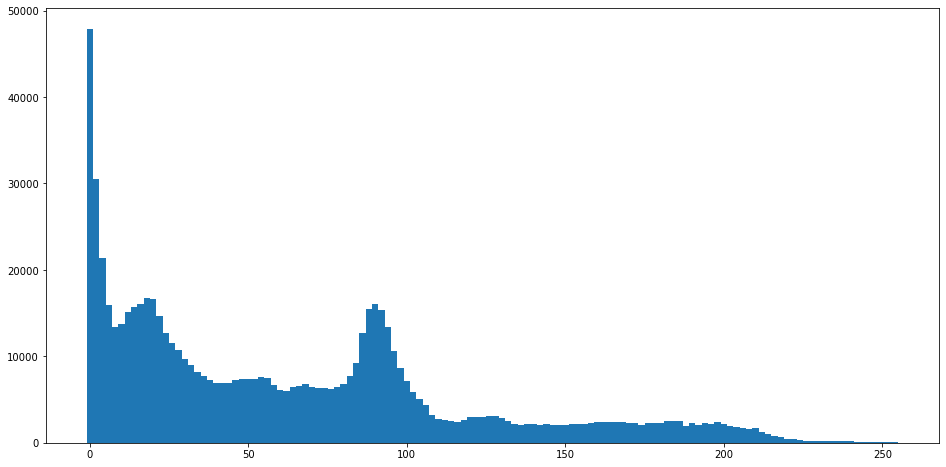

In [9]:
plt.figure(figsize=(16, 8))
plt.bar(h_bins[:-1], h_hist, width=2)
plt.show()